In [1]:
import pandas as pd
import numpy as np

In [2]:
housetrain = pd.read_csv(r"C:\Users\broga\OneDrive\Desktop\MSBA\Computing_ML\Final\Regression\train_new.csv")
housetrain.head()

,SalePrice,PID,Lot Frontage,Lot Area,Street,Neighborhood,Bldg Type,House Style,Overall Qual,Overall Cond,...,Full Bath,Half Bath,Bedroom AbvGr,TotRms AbvGrd,Gr Liv Area,Functional,Screen Porch,Pool Area,Yr Sold,Sale Type
0,159000,531363010,80.0,9605,Pave,SawyerW,1Fam,1Story,7,6,...,1,1,3,6,1218,Typ,0,0,2009,WD
1,271900,906203120,90.0,14684,Pave,SawyerW,1Fam,1Story,7,7,...,2,0,3,7,2196,Typ,0,0,2009,WD
2,137500,916176030,NaN,14375,Pave,Timber,1Fam,SLvl,6,6,...,1,0,3,7,1344,Typ,233,0,2009,COD
3,248500,528180130,48.0,6472,Pave,NridgHt,TwnhsE,1Story,9,5,...,2,0,2,6,1456,Typ,0,0,2009,WD
4,167000,528290030,61.0,9734,Pave,Gilbert,1Fam,SLvl,7,5,...,2,1,3,7,1374,Typ,0,0,2009,WD


In [4]:
#housetrain.info()
mean_lotfront = housetrain['Lot Frontage'].mean()
housetrain['Lot Frontage'].fillna(mean_lotfront, inplace=True)
cat_cols = ['Street', 'Neighborhood', 'Bldg Type', 'House Style', 'Roof Style', 'Heating', 'Central Air', 'Electrical', 'Functional', 'Sale Type','Yr Sold','Overall Qual','Overall Cond']
housetrain[cat_cols] = housetrain[cat_cols].astype('category')
#Convert PID to an object
housetrain['PID'] = housetrain['PID'].astype('object')
#Fill in electricla na
mode_electrical = housetrain['Electrical'].mode()[0]
housetrain['Electrical'].fillna(mode_electrical, inplace=True)

In [8]:
#Create X and y and drop predicting + any identifying columns
X = housetrain.drop(["SalePrice","PID"], axis = 1)
y = housetrain["SalePrice"]

In [9]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import make_column_selector

ct = ColumnTransformer(
    [
        ("dummify", OneHotEncoder(sparse_output=False, handle_unknown='ignore'),
         make_column_selector(dtype_include=['category','object'])), 
        ("standardize", StandardScaler(), make_column_selector(dtype_include=np.number))
    ],
    remainder="passthrough"
)

In [11]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score

# RF Tuning
rf_pipeline = Pipeline([
    ("preprocessing", ct),
    ("rf_classification", RandomForestRegressor(random_state=1))
])

param_grid = {
    "rf_classification__n_estimators": [75,100,125],
    "rf_classification__max_depth": [8,10,12],
    "rf_classification__min_samples_leaf": [2,4,6]
}

# Assuming rf_pipeline and param_grid are already defined
grid_search = GridSearchCV(rf_pipeline, param_grid, cv=5, scoring='neg_mean_squared_error', verbose=1)

grid_search.fit(X, y)

print("Best parameters:", grid_search.best_params_)

best_rf_rmse = np.sqrt(-grid_search.best_score_)
print(f"Best Random Forest Model RMSE: {best_rf_rmse}")

Fitting 5 folds for each of 27 candidates, totalling 135 fits
Best parameters: {'rf_classification__max_depth': 12, 'rf_classification__min_samples_leaf': 2, 'rf_classification__n_estimators': 75}
Best Random Forest Model RMSE: 29728.004967324465


In [14]:

rf_pipeline = Pipeline(
    [("preprocessing", ct),
     ("rf_regression", RandomForestRegressor(n_estimators=75,max_depth=12,min_samples_leaf=2,random_state=1))]
)

rf_model = rf_pipeline.fit(X,y)


#log_y = np.log(y)
rf_scores = cross_val_score(rf_model, X, y, cv=5, scoring='neg_mean_squared_error')
log_rmse_scores = np.sqrt(-rf_scores)
mean_log_rmse = log_rmse_scores.mean()

print(f"Random Forest Model Log Root Mean Squared Error: {mean_log_rmse}")

Random Forest Model Log Root Mean Squared Error: 29517.03956340266


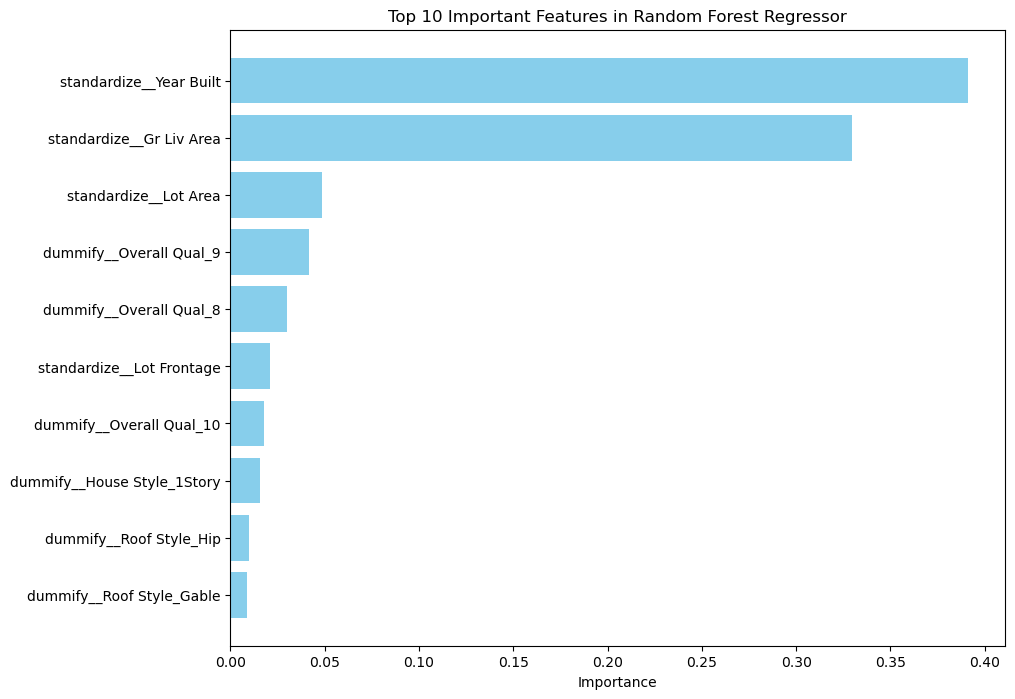

In [21]:
import matplotlib.pyplot as plt
import numpy as np  # Ensure numpy is imported

# Step 1: Extract feature importances
feature_importances = rf_model.named_steps['rf_regression'].feature_importances_
feature_names_transformed = rf_model.named_steps['preprocessing'].get_feature_names_out()

# Step 2: Map names to importances and sort
importance_dict = dict(zip(feature_names_transformed, feature_importances))
important_features = sorted(importance_dict.items(), key=lambda item: item[1], reverse=True)[:10]

# Extracting the feature names and their importances for plotting
feature_names, importances = zip(*important_features)

# Step 3: Create a bar chart
plt.figure(figsize=(10, 8))
plt.barh(feature_names, importances, color='skyblue')
plt.xlabel('Importance')
plt.title('Top 10 Important Features in Random Forest Regressor')
plt.gca().invert_yaxis()  # Display the most important feature at the top
plt.show()


In [15]:
housetest = pd.read_csv(r"C:\Users\broga\OneDrive\Desktop\MSBA\Computing_ML\Final\Regression\test_new.csv")
housetest.head()

,PID,Lot Frontage,Lot Area,Street,Neighborhood,Bldg Type,House Style,Overall Qual,Overall Cond,Year Built,...,Full Bath,Half Bath,Bedroom AbvGr,TotRms AbvGrd,Gr Liv Area,Functional,Screen Porch,Pool Area,Yr Sold,Sale Type
0,907135180,60,8070,Pave,CollgCr,1Fam,1Story,4,5,1994,...,1,0,3,5,990,Typ,0,0,2007,WD
1,528181040,40,6792,Pave,NridgHt,TwnhsE,1Story,7,5,2005,...,2,0,2,6,1368,Typ,0,0,2006,New
2,528175010,44,6371,Pave,NridgHt,TwnhsE,1Story,7,5,2009,...,2,0,2,6,1358,Typ,0,0,2010,New
3,531379030,70,8304,Pave,SawyerW,1Fam,2Story,6,5,1997,...,2,1,3,7,1837,Typ,0,0,2006,WD
4,923275090,37,6951,Pave,Mitchel,1Fam,1Story,5,5,1984,...,1,0,3,5,923,Typ,0,0,2008,WD


In [17]:
housetest[cat_cols] = housetest[cat_cols].astype('category')
#Convert PID to an object
housetest['PID'] = housetest['PID'].astype('object')
#Make predictions
predicted_prices = rf_model.predict(housetest)
#housetest.info()

In [19]:
#Add predictions to test df
housetest["SalePrice"] = predicted_prices
finaltestdf = housetest[["PID","SalePrice"]].copy()

In [20]:
finaltestdf

,PID,SalePrice
0,907135180,140830.265014
1,528181040,199472.210706
2,528175010,214663.511422
3,531379030,209894.931537
4,923275090,128433.589107
...,...,...
600,528174060,196122.607620
601,903400180,185823.429087
602,903227150,133340.123121
603,909250070,145615.333288


In [ ]:
#finaltestdf.to_csv(r"C:\Users\broga\OneDrive\Desktop\MSBA\Computing_ML\Final\Regression\Pietrocini_Regression_2.csv",index=False)